In [1]:
VariableName_unit = 0
# Variable names ending in an underscore are non-dimensional:
VariableName_ = 0
DesignGrossWeight_kg = 15

In [3]:
# Take-off performance
GroundRun_feet = 197
TakeOffSpeed_KCAS = 31
TakeOffElevation_feet = 0
# Cruise
# The cruising altitude may be viewed in two fundamentalways. First, itmay be a constraint – for
# example, due to regulatory requirements the aircraft may have to cruise at, say, 350 feet. It can
# also be viewed as a design variable, in which case you may wish to return to this point in the
# document and revise it as part of an iterative process of optimization / reinement.
CruisingAlt_feet = 400
CruisingSpeed_KTAS = 58.3

In [4]:
# Climb Performance
# The climb performance of an aircraft and its variation with altitude is the result of
# a complex web of interactions between the aerodynamics of lift generation and the
# response of its powerplant to varying atmospheric conditions and airspeed. Typically a
# range of design points have to be considered, representing a variety of conditions, but
# at this early stage in the design process it is best to keep the number of these design
# points at a more manageable level. Here we use 80% of the cruise speed for the climb
# constraint.
RateOfClimb_fpm = 591
ClimbSpeed_KCAS = CruisingSpeed_KTAS * 0.8
# The rate of climb constraint will be evaluated at this altitude:
ROCAlt_feet = 0

In [5]:
# Turn Performance
# We deine steady, level turn performance in terms of the load factor n (which represents the
# ratio of lift and weight). n = 1∕ cos ���, where ��� is the bank angle (so n = 1.41 corresponds to
# 45∘, n = 2 corresponds to 60∘, etc.).
n_cvt_ = 1.41
# Service Ceiling
ServiceCeiling_feet = 500

In [6]:
# Approach and Landing
ApproachSpeed_KTAS = 29.5
# We deine the margin by which the aircraft operates above its stall speed on inal approach
# (e.g., a reserve factor of 1.2 – typical of manned military aircraft – means lying 20% above
# stall, a reserve factor of 1.3 – typical of civil aircraft, means 30% above stall; for small UAVs,
# lower values may be considered).
StallReserveFactor = 1.1
StallSpeedinApproachConf_KTAS = ApproachSpeed_KTAS\
/StallReserveFactor
print(f"Stall speed in approach configuration: {StallSpeedinApproachConf_KTAS} KTAS")
# Stall speed in approach configuration: 26.8 KTAS
# Maximum lift coeficient in landing coniguration:
CLmax_approach = 1.3
# We also deine the highest altitude AMSL where we would expect the aircraft to be established
# on a stable inal approach in landing coniguration:
TopOfFinalApp_feet = 100

Stall speed in approach configuration: 26.818181818181817 KTAS


In [7]:
# Unit Conversions
# All constraint analysis calculations in this document are performed in SI units. However, it is
# more common to specify some elements of the design brief in the mix of SI and Imperial units
# traditionally used in aviation – here we perform the appropriate conversions.
CruisingAlt_m = CruisingAlt_feet*0.3048
print (f"Cruising altitude: {CruisingAlt_m}")
# Cruising altitude: 122 m
TopOfFinalApp_m = TopOfFinalApp_feet*0.3048
print(f"Top of final approach: {TopOfFinalApp_m} m")
# Top of final approach: 30 m
TakeOffElevation_m = TakeOffElevation_feet*0.3048
print (f"Take-off runway elevation: {TakeOffElevation_m} m")

# Take-off runway elevation: 0 m

Cruising altitude: 121.92
Top of final approach: 30.48 m
Take-off runway elevation: 0.0 m


In [8]:
ServiceCeiling_m = ServiceCeiling_feet*0.3048
print(f"Service ceiling: {ServiceCeiling_m} m")
# Service ceiling: 152 m
CruisingSpeed_mpsTAS = CruisingSpeed_KTAS*0.5144444444
print(f"Cruising speed: {CruisingSpeed_mpsTAS} m/s TAS")
# Cruising speed: 30.0 m/s TAS
ClimbSpeed_mpsCAS = ClimbSpeed_KCAS*0.5144444444
print(f"Climb speed: {ClimbSpeed_mpsCAS} m/s CAS")
# Climb speed: 24.0 m/s CAS
ApproachSpeed_mpsTAS = ApproachSpeed_KTAS*0.5144444444
print(f"Approach speed: {ApproachSpeed_mpsTAS} m/s TAS")
# Approach speed: 15.2 m/s TAS
StallSpeedinApproachConf_mpsTAS = StallSpeedinApproachConf_KTAS\
*0.51444444444
print(f"Stall speed in approach configuration: {StallSpeedinApproachConf_mpsTAS} m/s TAS")
# Stall speed in approach configuration: 13.8 m/s TAS
RateOfClimb_mps = RateOfClimb_fpm*0.00508
print(f"Rate of climb: {RateOfClimb_mps} m/s")
# Rate of climb: 3.0 m/s
TakeOffSpeed_mpsCAS = TakeOffSpeed_KCAS*0.5144444444
print(f"Take-off speed: {TakeOffSpeed_mpsCAS} m/s CAS")
# Take-off speed: 15.9 m/s CAS
GroundRun_m = GroundRun_feet*0.3048
print(f"Ground run: {GroundRun_m} m")
# Ground run: 60 m

Service ceiling: 152.4 m
Cruising speed: 29.99211110852 m/s TAS
Climb speed: 23.993688886816003 m/s CAS
Approach speed: 15.1761111098 m/s TAS
Stall speed in approach configuration: 13.796464646345454 m/s TAS
Rate of climb: 3.0022800000000003 m/s
Take-off speed: 15.9477777764 m/s CAS
Ground run: 60.0456 m


In [9]:
# Basic Geometry and Initial Guesses
# Almost by deinition, the early part of the conceptual design process is the only part of the
# product development where we do not yet have a geometry model to refer to. Thus, some of
# the all-important aerodynamic igures have to be guessed at this point, largely on the basis of
# high level geometrical parameters like the aspect ratio.
AspectRatio_ = 9
CDmin = 0.0418
WSmax_kgm2 = 20
TWmax = 0.6
Pmax_kW = 4
# Estimated take-off parameters
CLTO = 0.97
CDTO = 0.0898
muTO = 0.17

In [10]:
# Preamble
# Some of the computations and visualizations performed in this document may require additional
# Python modules; these need to be loaded irst as follows:
%matplotlib inline
import math
from aerocalc3 import std_atm as ISA
import numpy as np
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

In [11]:
def ConstraintPoly(WSl,TWl,Col,al):
    WSl.append(WSl[-1])
    TWl.append(0)
    WSl.append(WSl[0])
    TWl.append(0)
    WSl.append(0)
    TWl.append(TWl[-2])
    zp = zip(WSl,TWl)
    print(zp, "zp")
    print(type(zp), " type of zp")
#     print(list(zp), " list of zp")

    pa = matplotlib.patches.Polygon(list(zp), closed=True, color=Col, alpha=al)
    return pa

In [12]:
# Next, we deine a method for setting the appropriate bounds on each constraint diagram:
def PlotSetUp(Xmin, Xmax, Ymin, Ymax, Xlabel, Ylabel):
    pylab.ylim([Ymin,Ymax])
    pylab.xlim([Xmin,Xmax])
    pylab.ylabel(Ylabel)
    pylab.xlabel(Xlabel)
Resolution = 2000
Start_Pa = 0.1

In [13]:
# Preliminary Calculations
# The Operating Environment
# The environment in which the aircraft is expected to operate plays a very important role in
# many of the conceptual design calculations to follow. The conditions corresponding to the
# current design brief are computed as follows:
SeaLevelDens_kgm3 = ISA.alt2density(0, alt_units='ft',
density_units='kg/m**3')
print(f" ISA density at Sea level elevation: {SeaLevelDens_kgm3} kg/m^3")
# ISA density at Sea level elevation: 1.225 kg/m^3
TakeOffDens_kgm3 = ISA.alt2density(TakeOffElevation_feet, alt_units='ft', density_units='kg/m**3')
print(f" ISA density at take-off elevation: {TakeOffDens_kgm3} kg/m^3")
# ISA density at take-off elevation: 1.225 kg/m^3
ClimbAltDens_kgm3 = ISA.alt2density(ROCAlt_feet, alt_units='ft',
density_units='kg/m**3')
print(f" ISA density at the climb constraint altitude: {ClimbAltDens_kgm3} kg/m^3")
# ISA density at the climb constraint altitude: 1.225 kg/m^3
CruisingAltDens_kgm3 = ISA.alt2density(CruisingAlt_feet,\
alt_units='ft', density_units='kg/m**3')
print(f" ISA density at cruising altitude: {CruisingAltDens_kgm3} kg/m^3")
# ISA density at cruising altitude: 1.211 kg/m^3
# Concept Design: Initial Constraint Analysis 153
TopOfFinalAppDens_kgm3 = ISA.alt2density(TopOfFinalApp_feet,\
alt_units='ft', density_units='kg/m**3')
print(f" ISA density at the top of the final approach: {TopOfFinalAppDens_kgm3} kg/m^3")
# ISA density at the top of the final approach: 1.221 kg/m^3

 ISA density at Sea level elevation: 1.225 kg/m^3
 ISA density at take-off elevation: 1.225 kg/m^3
 ISA density at the climb constraint altitude: 1.225 kg/m^3
 ISA density at cruising altitude: 1.2107258584719596 kg/m^3
 ISA density at the top of the final approach: 1.2214194591117506 kg/m^3


In [14]:
# Basic Aerodynamic Performance Calculations
# In the absence of a geometry, at this stage any aerodynamic performance estimates will either
# be based on very basic physics or simple, empirical equations.
# We begin with a very rough estimate of the Oswald span eficiency, only suitable for moderate
# aspect ratios and sweep angles below 30∘ (equation due to Raymer):
e0 = 1.78*(1-0.045*AspectRatio_**0.68)-0.64
print(f"{e0} ")
# 0.783
# Lift induced drag factor k (Cd = Cd0
# + kC2
# l ):
k = 1.0/(math.pi*AspectRatio_*e0)
print(f"{k}")
# 0.045
# Dynamic pressure at cruise
q_cruise_Pa = 0.5*CruisingAltDens_kgm3*(CruisingSpeed_mpsTAS**2)
print(f"{q_cruise_Pa} Pa")
# 544.5 Pa
# Dynamic pressure in the climb
q_climb_Pa = 0.5*ClimbAltDens_kgm3*(ClimbSpeed_mpsCAS**2)
print(f"{q_climb_Pa} Pa")
# 352.6 Pa
# Dynamic pressure at take-off conditions – for the purposes of this simple approximation we
# assume the acceleration during the take-off run to decrease linearly with ���2, so for the ���2 term
# we’ll use half of the square of the liftoff velocity (i.e., ��� = ���TO∕
# √
# 2):
q_TO_Pa = 0.5*TakeOffDens_kgm3*(TakeOffSpeed_mpsCAS\
/math.sqrt(2))**2
print(f"{q_TO_Pa} Pa")
# 77.9 Pa

0.7831239342794879 
0.045162411188559015
544.5401354396214 Pa
352.61447766835715 Pa
77.8890574016653 Pa


In [15]:
q_APP_Pa = 0.5*TopOfFinalAppDens_kgm3\
*StallSpeedinApproachConf_mpsTAS**2
print(f"{q_APP_Pa} Pa")
# 116.2 Pa

116.24397806318478 Pa


In [16]:
# Constraints
# With the basic numbers of the current conceptual design iteration in place, we now draw up
# the boundaries of the wing loading W∕S versus thrust to weight ratio T∕W design domain.
# These boundaries are representations of the basic constraints that enforce the adherence of the
# design to the numbers speciied in the design brief.
# Constraint 1: Level, Constant Velocity Turn
# First, we compute the thrust to weight ratio required to maintain a speciic load factor n in a
# level turn at the cruise altitude:
# T
# W
# = q
# [
# CDmin
# W∕S
# + k
# (
# n
# q
# )2 (
# W
# S
# )]
# …or, in Python:
WSlistCVT_Pa = np.linspace(Start_Pa,8500,Resolution)
TWlistCVT = []
i = 0
for WS in WSlistCVT_Pa:
    TW = q_cruise_Pa*(CDmin/WSlistCVT_Pa[i] + WSlistCVT_Pa[i]\
    *k*(n_cvt_/q_cruise_Pa)**2)
    TWlistCVT.append(TW)
    i = i + 1
WSlistCVT_kgm2 = [x*0.101971621 for x in WSlistCVT_Pa]
print(WSlistCVT_kgm2[:10])
print(TWlistCVT[:10])

[0.0101971621, 0.44378824831205593, 0.8773793345241119, 1.3109704207361679, 1.744561506948224, 2.17815259316028, 2.611743679372336, 3.045334765584392, 3.478925851796448, 3.9125169380085043]
[227.61779310242503, 5.230814100820385, 2.646859824635679, 1.7726062691863724, 1.3332729415255957, 1.0691293692687447, 0.8929226757969303, 0.7670918212979806, 0.6728012378383549, 0.5995649027916633]


In [17]:
# The load factor n is the inverse of the cosine of the bank angle (denoted here by ���) so the
# latter can be calculated as: ��� = cos−1
# (
# 1
# n
# )
# so ���, in degrees, equals:
theta_deg = math.acos(1/n_cvt_)*180/math.pi
print(f"{theta_deg}\xb0")
# 45∘

44.828523754439736°


<zip object at 0x000002AB58DFF6C8> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


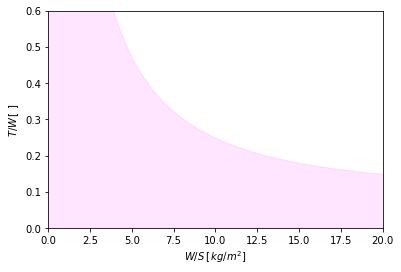

In [18]:
ConstVeloTurnPoly = ConstraintPoly(WSlistCVT_kgm2,TWlistCVT,"magenta", 0.1)

figCVT = plt.figure()
PlotSetUp(0, WSmax_kgm2, 0, TWmax, '$W/S\,[\,kg/m^2]$', '$T/W\,[\,\,]$')
axCVT = figCVT.add_subplot(111)
axCVT.add_patch(ConstVeloTurnPoly)


In [19]:
# Constraint 2: Rate of Climb

In [20]:
WSlistROC_Pa = np.linspace(Start_Pa,8500,Resolution)
TWlistROC = []
i = 0
for WS in WSlistROC_Pa:
    TW = RateOfClimb_mps/ClimbSpeed_mpsCAS + CDmin\
    *q_climb_Pa/WSlistROC_Pa[i] + k*WSlistROC_Pa[i]/q_climb_Pa
    TWlistROC.append(TW)
    i = i + 1
WSlistROC_kgm2 = [x*0.101971621 for x in WSlistROC_Pa]

<zip object at 0x000002AB58E3FF08> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


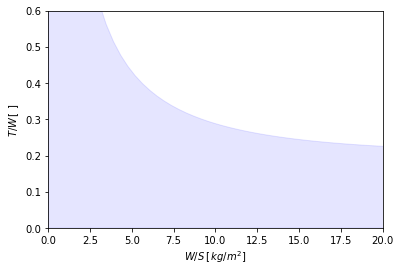

In [21]:
RateOfClimbPoly = ConstraintPoly(WSlistROC_kgm2,TWlistROC\
,'blue',0.1)
figROC = plt.figure()
PlotSetUp(0, WSmax_kgm2, 0, TWmax, '$W/S\,[\,kg/m^2]$'\
, '$T/W\,[\,\,]$')
axROC = figROC.add_subplot(111)
axROC.add_patch(RateOfClimbPoly)

In [22]:
# Constraint 3: Take-Off Ground Run Constraint

In [23]:
WSlistGR_Pa = np.linspace(Start_Pa,8500,Resolution)
TWlistGR = []
i = 0
for WS in WSlistGR_Pa:
    TW =(TakeOffSpeed_mpsCAS**2)/(2*9.81*GroundRun_m) + \
    q_TO_Pa*CDTO/WSlistGR_Pa[i]\
    + muTO*(1-q_TO_Pa*CLTO/WSlistGR_Pa[i])
    TWlistGR.append(TW)
    i = i + 1
WSlistGR_kgm2 = [x*0.101971621 for x in WSlistGR_Pa]

<zip object at 0x000002AB5B0361C8> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


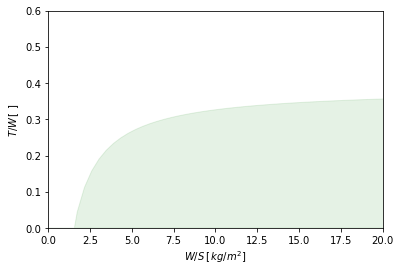

In [24]:
TORunPoly = ConstraintPoly(WSlistGR_kgm2,TWlistGR,"green",0.1)
figTOR = plt.figure()
PlotSetUp(0, WSmax_kgm2, 0, TWmax, "$W/S\,[\,kg/m^2]$"\
, "$T/W\,[\,\,]$")
axTOR = figTOR.add_subplot(111)
axTOR.add_patch(TORunPoly)

In [25]:
# Desired Cruise Airspeed

In [26]:
WSlistCR_Pa = np.linspace(Start_Pa,8500,Resolution)
TWlistCR = []
i = 0
for WS in WSlistCR_Pa:
    TW = q_cruise_Pa*CDmin*(1.0/WSlistCR_Pa[i])\
    + k*(1/q_cruise_Pa)*WSlistCR_Pa[i]
    TWlistCR.append(TW)
    i = i + 1
WSlistCR_kgm2 = [x*0.101971621 for x in WSlistCR_Pa]
CruisePoly = ConstraintPoly(WSlistCR_kgm2,TWlistCR,"red",0.1)

<zip object at 0x000002AB5B0ADBC8> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


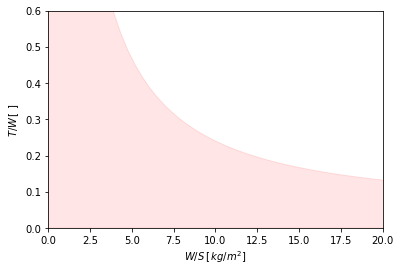

In [27]:
figCruise = plt.figure()
PlotSetUp(0, WSmax_kgm2, 0, TWmax, "$W/S\,[\,kg/m^2]$"\
, "$T/W\,[\,\,]$")
axCruise = figCruise.add_subplot(111)
axCruise.add_patch(CruisePoly)

In [28]:
# Constraint 5: Approach Speed

15.409662936968813 kg/m^2
<zip object at 0x000002AB5B155FC8> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


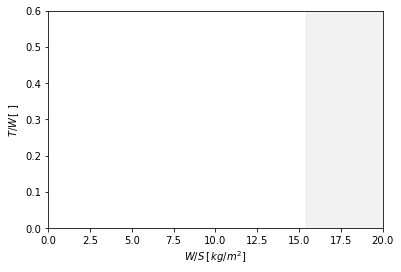

In [29]:
WS_APP_Pa = q_APP_Pa*CLmax_approach
WS_APP_kgm2 = WS_APP_Pa*0.101971621
print(f"{WS_APP_kgm2} kg/m^2")
# 15.41 kg/m^2
WSlistAPP_kgm2 = [WS_APP_kgm2, WSmax_kgm2, WSmax_kgm2\
, WS_APP_kgm2, WS_APP_kgm2 ]
TWlistAPP = [0, 0, TWmax, TWmax, 0 ]
AppStallPoly = ConstraintPoly(WSlistAPP_kgm2,TWlistAPP\
,"grey",0.1)
figAPP = plt.figure()
PlotSetUp(0, WSmax_kgm2, 0, TWmax, "$W/S\,[\,kg/m^2]$", "$T/W\,[\,\,]$")
axAPP = figAPP.add_subplot(111)
axAPP.add_patch(AppStallPoly)


In [30]:
# Combined Constraint Diagram

<zip object at 0x000002AB5AF83E88> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB58E3F9C8> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB58E3F988> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF83A08> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF83308> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0.05, 0.95, '\n The feasible aeroplanelives\n in this white space')

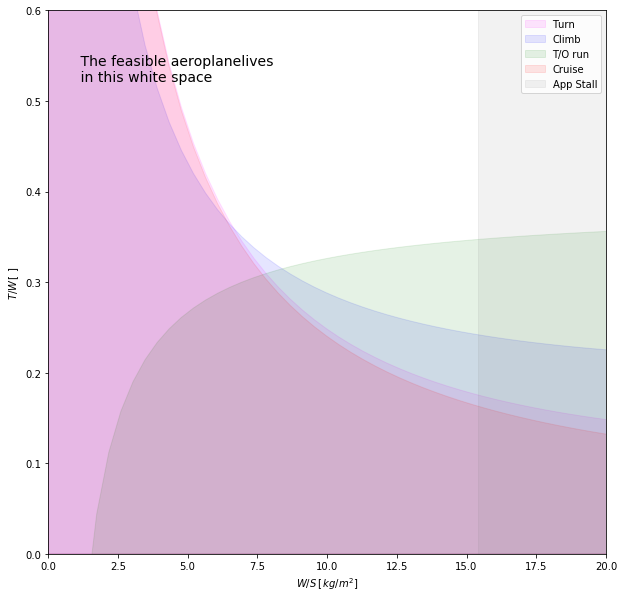

In [31]:
figCOMP = plt.figure(figsize = (10,10))
PlotSetUp(0, WSmax_kgm2, 0, TWmax, '$W/S\,[\,kg/m^2]$'\
, '$T/W\,[\,\,]$')
axCOMP = figCOMP.add_subplot(111)
ConstVeloTurnPoly = ConstraintPoly(WSlistCVT_kgm2\
,TWlistCVT,'magenta',0.1)
axCOMP.add_patch(ConstVeloTurnPoly)
RateOfClimbPoly = ConstraintPoly(WSlistROC_kgm2\
,TWlistROC,'blue',0.1)
axCOMP.add_patch(RateOfClimbPoly)
TORunPoly = ConstraintPoly(WSlistGR_kgm2,TWlistGR,'green',0.1)
axCOMP.add_patch(TORunPoly)
CruisePoly = ConstraintPoly(WSlistCR_kgm2,TWlistCR,'red',0.1)
axCOMP.add_patch(CruisePoly)
AppStallPoly = ConstraintPoly(WSlistAPP_kgm2,TWlistAPP,'grey',0.1)
axCOMP.add_patch(AppStallPoly)
axCOMP.legend(['Turn','Climb','T/O run','Cruise'\
, 'App Stall'])
textstr = '\n The feasible aeroplane\
lives\n in this white space'
axCOMP.text(0.05, 0.95, textstr, transform=axCOMP.transAxes\
, fontsize=14, verticalalignment='top')

In [32]:
# Since propeller and piston engine driven aircraft are normally designed in terms of engine
# power rather than thrust, we next convert the constraint diagram from thrust to weight
# ratio into an installed power requirement by specifying a propulsive eficiency ��� = 0.6
# (note that un-supercharged piston engine power varies with altitude so we also allow for
# this in the conversion using the Gagg and Ferrar model (see Gudmundsson [15]) with
# PowerSL = Power∕(1.132��� − 0.132) where ��� is the air density ratio):

In [33]:
PropEff = 0.6
WSlistCVT_Pa = np.linspace(Start_Pa,8500,Resolution)
PlistCVT_kW = []
i = 0
for WS in WSlistCVT_Pa:
    TW = q_cruise_Pa*(CDmin/WSlistCVT_Pa[i]\
    + WSlistCVT_Pa[i]*k*(n_cvt_/q_cruise_Pa)**2)
    P_kW = 9.81 * TW * DesignGrossWeight_kg\
    * CruisingSpeed_mpsTAS / PropEff \
    / (1.132*CruisingAltDens_kgm3/SeaLevelDens_kgm3-0.132)/1000
    PlistCVT_kW.append(P_kW)
    i = i + 1
WSlistCVT_kgm2 = [x*0.101971621 for x in WSlistCVT_Pa]


In [34]:
WSlistROC_Pa = np.linspace(Start_Pa,8500,Resolution)
PlistROC_kW = []
i = 0
for WS in WSlistROC_Pa:
    TW = RateOfClimb_mps/ClimbSpeed_mpsCAS\
    + CDmin*q_climb_Pa/WSlistROC_Pa[i] \
    + k*WSlistROC_Pa[i]/q_climb_Pa
    P_kW = 9.81 * TW * DesignGrossWeight_kg\
    * ClimbSpeed_mpsCAS / PropEff \
    / (1.132*ClimbAltDens_kgm3/SeaLevelDens_kgm3-0.132)/1000
    PlistROC_kW.append(P_kW)
    i = i + 1
WSlistROC_kgm2 = [x*0.101971621 for x in WSlistROC_Pa]

In [35]:
WSlistGR_Pa = np.linspace(Start_Pa,8500,Resolution)
PlistGR_kW = []
i = 0
for WS in WSlistGR_Pa:
    TW =(TakeOffSpeed_mpsCAS**2)/(2*9.81*GroundRun_m) + \
    q_TO_Pa*CDTO/WSlistGR_Pa[i]\
    + muTO*(1-q_TO_Pa*CLTO/WSlistGR_Pa[i])
    P_kW = 9.81 * TW * DesignGrossWeight_kg\
    * TakeOffSpeed_mpsCAS / PropEff \
    / (1.132*TakeOffDens_kgm3/SeaLevelDens_kgm3-0.132)/1000
    PlistGR_kW.append(P_kW)
    i = i + 1
WSlistGR_kgm2 = [x*0.101971621 for x in WSlistGR_Pa]

In [36]:
WSlistCR_Pa = np.linspace(Start_Pa,8500,Resolution)
PlistCR_kW = []
i = 0
for WS in WSlistCR_Pa:
    TW = q_cruise_Pa*CDmin*(1.0/WSlistCR_Pa[i])\
    + k*(1/q_cruise_Pa)*WSlistCR_Pa[i]
    P_kW = 9.81 * TW * DesignGrossWeight_kg\
    * CruisingSpeed_mpsTAS / PropEff \
    / (1.132*CruisingAltDens_kgm3/SeaLevelDens_kgm3-0.132)/1000
    PlistCR_kW.append(P_kW)
    i = i + 1
WSlistCR_kgm2 = [x*0.101971621 for x in WSlistCR_Pa]

In [37]:
WSlistAPP_kgm2 = [WS_APP_kgm2, WSmax_kgm2, WSmax_kgm2\
, WS_APP_kgm2, WS_APP_kgm2 ]
PlistAPP_kW = [0, 0, Pmax_kW, Pmax_kW, 0 ]

<zip object at 0x000002AB5B210CC8> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF6C1C8> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF7C248> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF7BE48> zp
<class 'zip'>  type of zp
<zip object at 0x000002AB5AF7F108> zp
<class 'zip'>  type of zp


c:\users\geoff\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0.05, 0.95, '\n The feasible aeroplanelives\n in this white space')

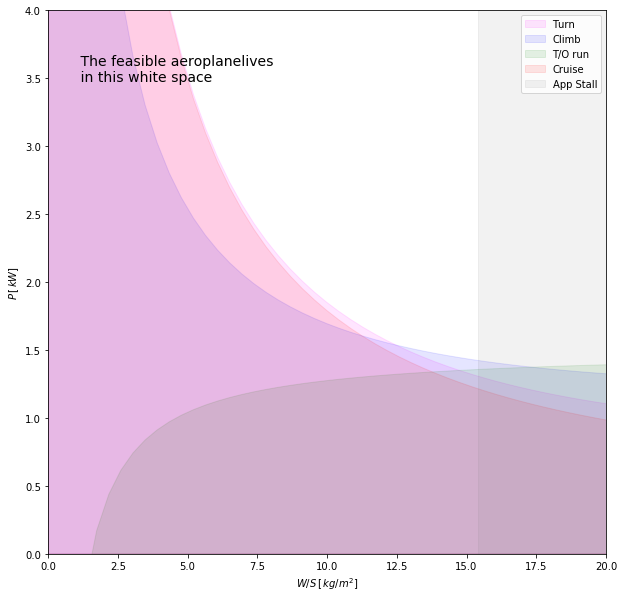

In [39]:
figCOMP = plt.figure(figsize = (10,10))
PlotSetUp(0, WSmax_kgm2, 0, Pmax_kW, '$W/S\,[\,kg/m^2]$'\
, '$P\,[\,kW]$')
axCOMP = figCOMP.add_subplot(111)
ConstVeloTurnPoly = ConstraintPoly(WSlistCVT_kgm2,PlistCVT_kW\
,'magenta',0.1)
axCOMP.add_patch(ConstVeloTurnPoly)
RateOfClimbPoly = ConstraintPoly(WSlistROC_kgm2,PlistROC_kW\
,'blue',0.1)
axCOMP.add_patch(RateOfClimbPoly)
TORunPoly = ConstraintPoly(WSlistGR_kgm2,PlistGR_kW,'green',0.1)
axCOMP.add_patch(TORunPoly)
CruisePoly = ConstraintPoly(WSlistCR_kgm2,PlistCR_kW,'red',0.1)
axCOMP.add_patch(CruisePoly)
AppStallPoly = ConstraintPoly(WSlistAPP_kgm2,PlistAPP_kW,'grey',0.1)
axCOMP.add_patch(AppStallPoly)
axCOMP.legend(['Turn','Climb','T/O run','Cruise', 'App Stall'])
textstr = '\n The feasible aeroplane\
lives\n in this white space'
axCOMP.text(0.05, 0.95, textstr, transform=axCOMP.transAxes\
, fontsize=14, verticalalignment='top')